In [125]:
import numpy as np
from tqdm import tqdm
import gym
import math
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [126]:
env = gym.make('Taxi-v3')
num_actions = env.action_space
num_obs = env.observation_space
R, G, B, Y = env.unwrapped.locs
R, G, B, Y = list(R), list(G), list(B), list(Y)
env.reset()


(294, {'prob': 1.0, 'action_mask': array([1, 1, 0, 1, 0, 0], dtype=int8)})

In [127]:
def get_state(state):
    row, col, pass_id, dest_id = env.unwrapped.decode(state)
    state = np.asarray([row,col,pass_id,dest_id])
    return state

#encoding a 5x5 matrix as a 25x1 vector
def encode(pose):
    [row,col] = pose
    state_num = row * 5 + col
    return state_num

def decode(state_num):
    row = state_num // 5
    col = state_num % 5
    return row, col

print(R,G,B,Y)

[0, 0] [0, 4] [4, 0] [4, 3]


In [128]:
curr_state = get_state(env.s)
print("Taxi at",curr_state)
next_state, reward, done, _, _ = env.step(4)
row, col, pass_id, dest_id = env.unwrapped.decode(next_state)

Taxi at [2 4 3 2]


In [129]:
def choose_action(state,qs,eps):
    #print(np.shape(q))
    length = np.shape(qs)[1]
    if not qs[state].any():
        return random.randint(0,length-1)
    action = np.argmax(qs[state])
    
    if np.random.rand() < eps:
        action = np.random.randint(0,length-1)
        return action
    return action   

def choose_action_option(state,qs):
    action = np.argmax(qs[state])
    return action  

In [130]:
# Options where policy is greedy wrt the corresponding q Value function
def Red(q_r,state,eps):
    optdone = False
    optact = choose_action(state,q_r,eps)
    state = decode(state)
    if state[0] == R[0] and state[1] == R[1]:
        optdone = True
    return optact,optdone

def Green(q_g,state,eps):
    optdone = False
    optact = choose_action(state,q_g,eps)
    state = decode(state)
    if state[0] == G[0] and state[1] == G[1]:
        optdone = True
    return optact,optdone
    
def Yellow(q_y,state,eps):
    optdone = False
    optact = choose_action(state,q_y,eps)
    state = decode(state)
    if state[0] == Y[0] and state[1] == Y[1]:
        optdone = True
    return optact,optdone 

def Blue(q_b,state,eps):
    optdone = False
    optact = choose_action(state,q_b,eps)
    state = decode(state)
    if state[0] == B[0] and state[1] == B[1]:
        optdone = True
    return optact,optdone 

In [131]:
Q_opt = np.zeros((4,25,4))
q = np.zeros((500,10))
qf = np.zeros((500,10))
qof = np.zeros((4,25,4))

### Hardcoded policy

In [132]:


policyOptionR = np.array([[1,3,0,0,0],
                 [1,3,0,0,0],
                 [1,3,3,3,3],
                 [1,1,1,1,1],
                 [1,1,1,1,1]
                 ]).flatten()

policyOptionG = np.array([[0,0,2,2,1],
                 [0,0,2,2,1],
                 [2,2,2,1,1],
                 [1,2,1,1,1],
                 [1,2,1,1,1]
                 ]).flatten()

policyOptionY = np.array([[0,3,0,0,0],
                          [0,3,0,0,0],
                          [0,3,3,3,3],
                          [0,1,1,1,3],
                          [0,1,3,1,3]
                          ]).flatten()

policyOptionB = np.array([[0,0,0,0,3],
                          [0,0,0,0,3],
                          [2,2,2,0,3],
                          [1,1,1,0,3],
                          [1,1,1,0,3]
                          ]).flatten()

policyOpt = [policyOptionR,policyOptionG,policyOptionY,policyOptionB]
for index1, value1 in enumerate(policyOpt):
   for index2, value2  in enumerate(value1):
      Q_opt[index1][index2][value2] = 1
#print(Q_opt)


### SMDP

In [133]:
# Set the number of episodes and maximum number of steps per episode
EPS = 10000
MAX_STEPS = 500
EXP = 1
# Set the learning rate, discount factor, and exploration rate
ALPHA1 = 0.1
ALPHA2 = 0.1
GAMMA = 0.99
exploration_rate = 1.0
MIN_EXP = 0.01
EXP_DECAY = 0.01

In [134]:
q = np.zeros((500,10))
qf = np.zeros((500,10))
Q_opt = np.zeros((4,25,4))
qof = np.zeros((4,25,4))

class SMDP:
    def __init__(self):
        self.avg_reward = []
        self.total_reward = []

    def reset(self):
        q = np.zeros((500,10))
        qf = np.zeros((500,10))
        Q_opt = np.zeros((4,25,4))
        qof = np.zeros((4,25,4))


    def Qlearn(self,psuedo=False):
        for episode in tqdm(range(3000)):
            running = 0
            state, _ = env.reset()
            done = False
            ep_reward = 0
            steps = 0

            while not done :
                steps += 1
                epsilon = 0.15
                action = choose_action(state,q,epsilon)
                if action < 6:
                    next_state, reward, done, _, _ = env.step(action)
                    ep_reward += reward
                    q[state,action] = q[state, action] + ALPHA1 * (reward + GAMMA * np.max(q[next_state, :])- q[state, action])
                    qf[state,action] += 1
                    state = next_state
                
                reward_bar = 0
                if action > 5 :
                    count = 0
                    optdone = False
                    current_state = state
                    state = encode(get_state(state)[0:2]) 
                    epsilon = 0.2
                    while (optdone == False) :
                        if action == 6:
                            optact, optdone = Red(Q_opt[0],state,epsilon) 
                            next_state, reward, done, _, _ = env.step(optact)
                            next = encode(get_state(next_state)[0:2])
                            if optdone and psuedo:
                                Q_opt[0][state,optact] = Q_opt[0][state, optact] + ALPHA2* (reward + 20 + GAMMA * np.max(Q_opt[0][next])- Q_opt[0][state, optact])
                            else:
                                Q_opt[0][state,optact] = Q_opt[0][state, optact] + ALPHA2 * (reward + GAMMA * np.max(Q_opt[0][next, :])- Q_opt[0][state, optact])
                            qof[0][state,optact] += 1

                        if action == 7:
                            optact, optdone = Green(Q_opt[1],state,epsilon)
                            next_state, reward, done, _, _ = env.step(optact)
                            next = encode(get_state(next_state)[0:2])
                            if optdone and psuedo:
                                Q_opt[1][state,optact] = Q_opt[1][state, optact] + ALPHA2* (reward + 20 + GAMMA * np.max(Q_opt[1][next])- Q_opt[1][state, optact])
                            else:
                                Q_opt[1][state,optact] = Q_opt[1][state, optact] + ALPHA2 * (reward + GAMMA * np.max(Q_opt[1][next, :])- Q_opt[1][state, optact])
                            qof[1][state,optact] += 1

                        if action == 8:
                            optact, optdone = Blue(Q_opt[2],state,epsilon)
                            next_state, reward, done, _, _ = env.step(optact)
                            next = encode(get_state(next_state)[0:2])
                            if optdone and psuedo:
                                Q_opt[2][state,optact] = Q_opt[2][state, optact] + ALPHA2* (reward + 20 + GAMMA * np.max(Q_opt[2][next])- Q_opt[2][state, optact])
                            else:
                                Q_opt[2][state,optact] = Q_opt[2][state, optact] + ALPHA2* (reward + GAMMA * np.max(Q_opt[2][next, :])- Q_opt[2][state, optact])
                            qof[2][state,optact] += 1

                        if action == 9:

                            optact, optdone = Yellow(Q_opt[3],state,epsilon)
                            next_state, reward, done, _, _ = env.step(optact)
                            next = encode(get_state(next_state)[0:2])
                            if optdone and psuedo:
                                Q_opt[3][state,optact] = Q_opt[3][state, optact] + ALPHA2* (reward + 20 + GAMMA * np.max(Q_opt[3][next])- Q_opt[3][state, optact])
                            else:
                                Q_opt[3][state,optact] = Q_opt[3][state, optact] + ALPHA2* (reward + GAMMA * np.max(Q_opt[3][next])- Q_opt[3][state, optact])
                            qof[3][state,optact] += 1

                        reward_bar =  reward_bar + (GAMMA**count)*reward
                        ep_reward += reward
                        count += 1
                        state = next
                        if optdone == True:
                            q[current_state, action] += ALPHA1 * (reward_bar - q[current_state, action] + (GAMMA**count) * np.max(q[next_state, :]))
                            state = env.s
                        
            running = 0.05 * ep_reward + (1 - 0.05) * running
            self.avg_reward.append(running)
            self.total_reward.append(ep_reward)
            #print(f"Episode {episode + 1}: Total Reward = {running}")
        return self.avg_reward, self.total_reward
    
    def plot(self):
        plt.plot(self.avg_reward,label="Moving Average")
        plt.grid()
        plt.plot(self.total_reward,label="Total Rewards",alpha=0.71, color='blue')
        plt.xlabel('Episode')
        plt.ylabel('Averaged Episodic Returns')
        plt.title("Averaged Episodic Returns")
        plt.legend()
        plt.savefig('SMDP.png')
        plt.show()

    def render_run(self):
        special_env = gym.make('Taxi-v3',render_mode='human')
        done = False
        eps = 0.01
        state, _ = special_env.reset()
        while not done:
            action = choose_action(state,q,eps)
            next_state, reward, done, _, _ = special_env.step(action)
            if done:
                break

    def plot_Q(self):
     actions = ["south", "north", "east", "west"]
     ACTIONS = ["R", "G", "Y", "B"]
     fig, axes = plt.subplots(1, len(qof), figsize=(16, 4)) 
     fig.suptitle('Frequency Map with best action for each state')
     for ax, q_value,k in zip(axes, qof, ACTIONS):
        q_plot = np.zeros((5, 5, 4))
        for i in range(5):
            for j in range(5):
                state_num = i * 5 + j
                q_plot[i, j] = q_value[state_num]

        ax.set_title(f"Option {k}")
        ax.pcolor(q_plot.max(-1), edgecolors='k', linewidths=2)
        plt.colorbar(ax.pcolor(q_plot.max(-1)), ax=ax)
        for i in range(5):
            for j in range(5):
                state_num = i * 5 + j
                anno = actions[np.argmax(q_plot[i, j])][0]
                size = 'large'
                ax.text(j + 0.5, i + 0.5, anno, ha='center', va='center', color='red', size=size)
        ax.invert_yaxis()

        

Learning Options Without Psuedo-Reward

100%|██████████| 3000/3000 [00:14<00:00, 212.43it/s]


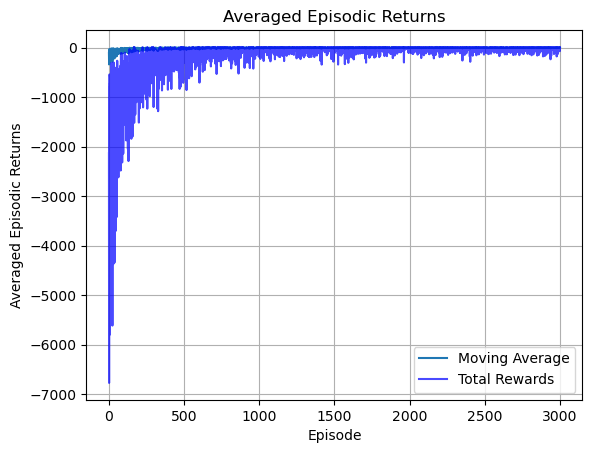

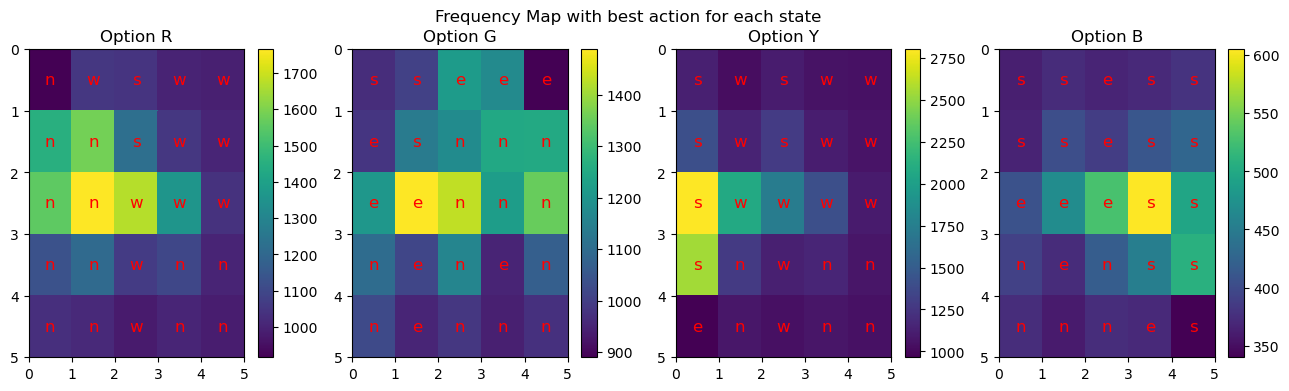

In [135]:
smdp = SMDP()
smdp.Qlearn(psuedo=False)
smdp.plot()
smdp.plot_Q()

Learning Options with Psuedo-Reward

100%|██████████| 3000/3000 [00:02<00:00, 1322.03it/s]


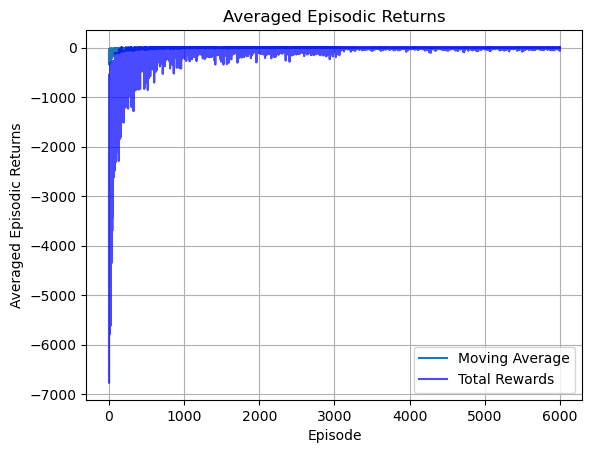

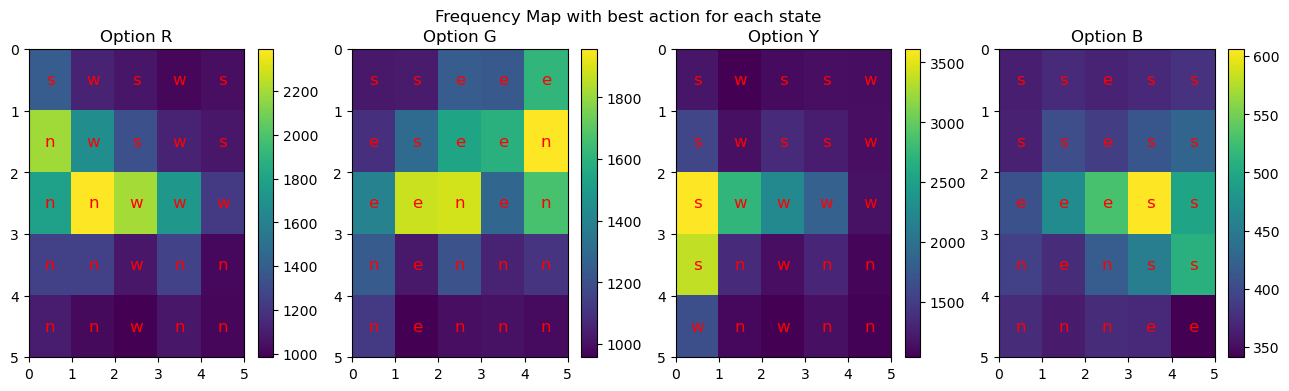

In [136]:
smdp.reset()
smdp.Qlearn(psuedo=True)
smdp.plot()
smdp.plot_Q()

### INTRA OPTION

In [137]:
# Set the number of episodes and maximum number of steps per episode
EPS = 10000
MAX_STEPS = 500
EXP = 1
# Set the learning rate, discount factor, and exploration rate
ALPHA1 = 0.1
ALPHA2 = 0.1
GAMMA = 0.99
exploration_rate = 1.0
MIN_EXP = 0.01
EXP_DECAY = 0.01

In [142]:
q_intra = np.zeros((500,10))
qf = np.zeros((500,10))
Q_opt = np.zeros((4,25,4))
qof = np.zeros((4,25,4))

In [143]:

def optdone_to_beta(optdone):
    if optdone == True:
        return 1
    return 0

class INTRAOPT:
    def __init__(self):
        self.avg_reward = []
        self.total_reward = []

    def reset(self):
        q_intra = np.zeros((500,10))
        qf = np.zeros((500,10))
        Q_opt = np.zeros((4,25,4))
        qof = np.zeros((4,25,4))


    def Qlearn(self,psuedo=False):
        for episode in tqdm(range(3000)):
            running = 0
            stateg, _ = env.reset()
            done = False
            ep_reward = 0
            steps = 0

            while not done :
                steps += 1
                epsilon = 0.15
                action = choose_action(stateg,q,epsilon)
                if action < 6:
                    next_state, reward, done, _, _ = env.step(action)
                    ep_reward += reward
                    q_intra[stateg,action] = q_intra[stateg, action] + ALPHA1 * (reward + GAMMA * np.max(q_intra[next_state, :])- q_intra[stateg, action])
                    qf[stateg,action] += 1
                    grid_state = encode(get_state(stateg)[0:2])
                    next = encode(get_state(next_state)[0:2])
                    for j in range(len(Q_opt)):
                        if np.argmax(Q_opt[j][grid_state]) == action:                                                                                     
                            Q_opt[j][grid_state][action] += ALPHA1 * (reward + GAMMA * np.max(Q_opt[j][next]) - Q_opt[j][grid_state][action])

                    stateg = next_state                                                                                                                                
                
                reward_bar = 0
                if action > 5 :
                    count = 0
                    optdone = False
                    current_state = stateg
                    state = encode(get_state(stateg)[0:2]) 
                    epsilon = 0.2
                    while (optdone == False) :
                        if action == 6:
                            optact, optdone = Red(Q_opt[0],state,epsilon) 
                            next_state, reward, done, _, _ = env.step(optact)
                            next = encode(get_state(next_state)[0:2])
                            if optdone and psuedo:
                                Q_opt[0][state,optact] = Q_opt[0][state, optact] + ALPHA2* (reward + 20 + GAMMA * np.max(Q_opt[0][next])- Q_opt[0][state, optact])
                            else:
                                Q_opt[0][state,optact] = Q_opt[0][state, optact] + ALPHA2 * (reward + GAMMA * np.max(Q_opt[0][next, :])- Q_opt[0][state, optact])
                            qof[0][state,optact] += 1

                        if action == 7:
                            optact, optdone = Green(Q_opt[1],state,epsilon)
                            next_state, reward, done, _, _ = env.step(optact)
                            next = encode(get_state(next_state)[0:2])
                            if optdone and psuedo:
                                Q_opt[1][state,optact] = Q_opt[1][state, optact] + ALPHA2* (reward + 20 + GAMMA * np.max(Q_opt[1][next])- Q_opt[1][state, optact])
                            else:
                                Q_opt[1][state,optact] = Q_opt[1][state, optact] + ALPHA2 * (reward + GAMMA * np.max(Q_opt[1][next, :])- Q_opt[1][state, optact])
                            qof[1][state,optact] += 1

                        if action == 8:
                            optact, optdone = Blue(Q_opt[2],state,epsilon)
                            next_state, reward, done, _, _ = env.step(optact)
                            next = encode(get_state(next_state)[0:2])
                            if optdone and psuedo:
                                Q_opt[2][state,optact] = Q_opt[2][state, optact] + ALPHA2* (reward + 20 + GAMMA * np.max(Q_opt[2][next])- Q_opt[2][state, optact])
                            else:
                                Q_opt[2][state,optact] = Q_opt[2][state, optact] + ALPHA2* (reward + GAMMA * np.max(Q_opt[2][next, :])- Q_opt[2][state, optact])
                            qof[2][state,optact] += 1

                        if action == 9:
                            optact, optdone = Yellow(Q_opt[3],state,epsilon)
                            next_state, reward, done, _, _ = env.step(optact)
                            next = encode(get_state(next_state)[0:2])
                            if optdone and psuedo:
                                Q_opt[3][state,optact] = Q_opt[3][state, optact] + ALPHA2* (reward + 20 + GAMMA * np.max(Q_opt[3][next])- Q_opt[3][state, optact])
                            else:
                                Q_opt[3][state,optact] = Q_opt[3][state, optact] + ALPHA2* (reward + GAMMA * np.max(Q_opt[3][next])- Q_opt[3][state, optact])
                            qof[3][state,optact] += 1

                        reward_bar =  reward_bar + (GAMMA**count)*reward
                        ep_reward += reward
                        count += 1
                        state = next
                        
                        U_intra = (1 - optdone_to_beta(optdone)) * q_intra[stateg, optact] + optdone_to_beta(optdone) * np.max(q_intra[next_state])
                        q_intra[stateg, action] += ALPHA1 * (reward - q_intra[stateg, action] + GAMMA* U_intra)
                        

            running = 0.05 * ep_reward + (1 - 0.05) * running
            self.avg_reward.append(running)
            self.total_reward.append(ep_reward)
            #print(f"Episode {episode + 1}: Total Reward = {running}")
        return self.avg_reward, self.total_reward
    
    def plot(self):
        plt.plot(self.avg_reward,label="Moving Average")
        plt.grid()
        plt.plot(self.total_reward,label="Total Rewards",alpha=0.71, color='blue')
        plt.xlabel('Episode')
        plt.ylabel('Averaged Episodic Returns')
        plt.title("Averaged Episodic Returns")
        plt.legend()
        plt.savefig('SMDP.png')
        plt.show()

    def render_run(self):
        special_env = gym.make('Taxi-v3',render_mode='human')
        done = False
        eps = 0.01
        state, _ = special_env.reset()
        while not done:
            action = choose_action(state,q,eps)
            next_state, reward, done, _, _ = special_env.step(action)
            if done:
                break

    def plot_Q(self):
     actions = ["south", "north", "east", "west"]
     ACTIONS = ["R", "G", "Y", "B"]
     fig, axes = plt.subplots(1, len(qof), figsize=(16, 4)) 
     fig.suptitle('Frequency Map with best action for each state')
     for ax, q_value,k in zip(axes, qof, ACTIONS):
        q_plot = np.zeros((5, 5, 4))
        for i in range(5):
            for j in range(5):
                state_num = i * 5 + j
                q_plot[i, j] = q_value[state_num]

        ax.set_title(f"Option {k}")
        ax.pcolor(q_plot.max(-1), edgecolors='k', linewidths=2)
        plt.colorbar(ax.pcolor(q_plot.max(-1)), ax=ax)
        for i in range(5):
            for j in range(5):
                state_num = i * 5 + j
                anno = actions[np.argmax(q_plot[i, j])][0]
                size = 'large'
                ax.text(j + 0.5, i + 0.5, anno, ha='center', va='center', color='red', size=size)
        ax.invert_yaxis()

        

100%|██████████| 3000/3000 [00:03<00:00, 920.25it/s] 


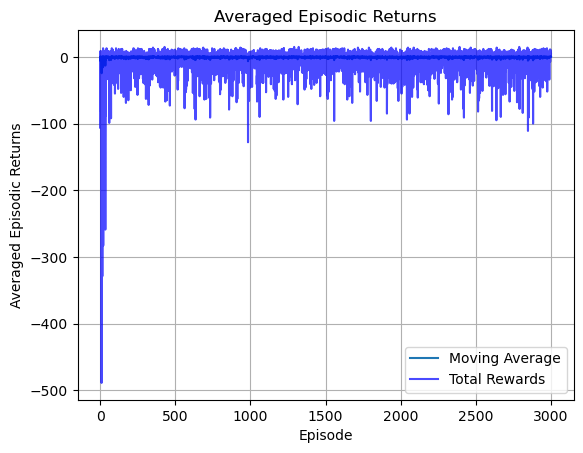

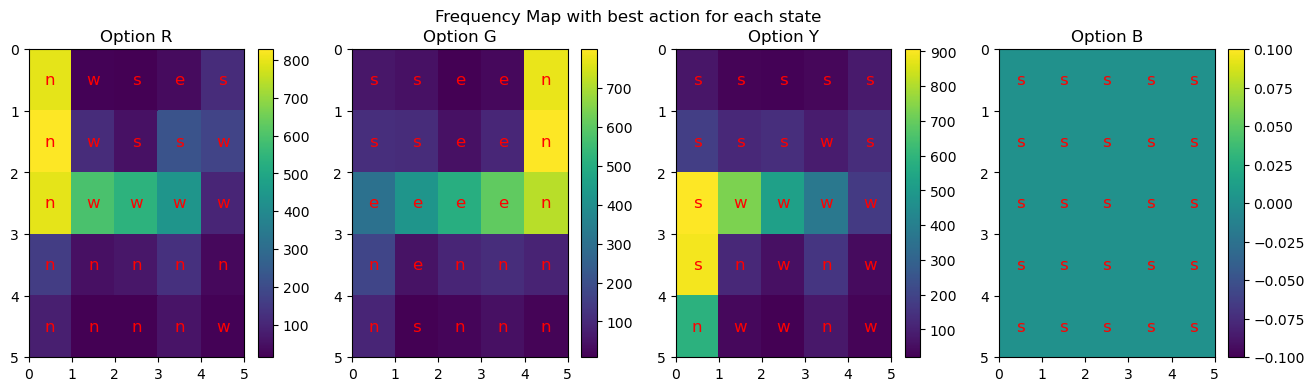

In [144]:
agent2 = INTRAOPT()
agent2.Qlearn(psuedo=True)
agent2.plot()
agent2.plot_Q()

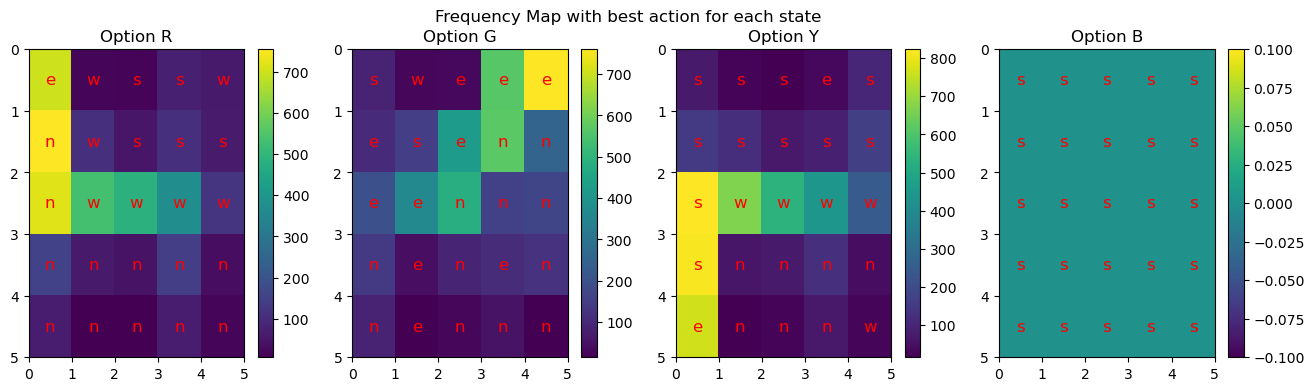

In [141]:
agent2.plot_Q()